# Desafío Spike

Este notebook presenta la solución para el desafío de precios de Spike. Todos los detalles del desafío están en el archivo XXX.

## 0. Setup de librerías

In [11]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import sweetviz as sv
%matplotlib inline

# 1. Importación de datos
Comenzamos revisando los datos de precipitaciones:

In [60]:
df_precipitaciones = pd.read_csv("data/precipitaciones.csv")

In [92]:
def set_datetime_index(data: pd.DataFrame, dt_column: str) -> pd.DataFrame:
    """
    Recibe un dataframe y un nombre de columna, retorna el dataframe con esa columna
    transformada a datetime como index
    """
    df = data.copy()
    df['_date'] = pd.to_datetime(pd.to_datetime(df[dt_column]).dt.date)
    df = df.set_index(df['_date'])
    df = df.drop('_date', axis=1)
    df = df.sort_values(by='_date', ascending=True)
    return df

In [62]:
df_precipitaciones = set_datetime_index(df_precipitaciones, 'date') 
print("Revisión visual de las primeras filas de los datos de precipitaciones:")
df_precipitaciones.head()

Revisión visual de las primeras filas de los datos de precipitaciones:


,date,Coquimbo,Valparaiso,Metropolitana_de_Santiago,Libertador_Gral__Bernardo_O_Higgins,Maule,Biobio,La_Araucania,Los_Rios
_date,,,,,,,,,
1979-01-01,1979-01-01,2.641948,0.587062,2.447114,1.608992,3.736215,17.859634,25.212940,45.596447
1979-02-01,1979-02-01,1.179804,2.432192,3.997852,4.346310,16.347637,17.680612,18.085072,34.075039
1979-03-01,1979-03-01,0.255490,0.020601,0.000000,0.055488,0.545324,14.435698,28.696504,66.232248
1979-04-01,1979-04-01,10.173699,11.745779,13.722349,12.989194,21.880607,39.136483,43.617921,73.548127
1979-05-01,1979-05-01,1.039098,18.609286,50.187148,104.451550,143.914334,219.729235,279.409718,438.005116


En primer lugar se utiliza sweetviz para crear un reporte rápido de los datos de precipitaciones que queda en el archivo XXXX.

In [29]:
reporte_precipitaciones = sv.analyze(df_precipitaciones)
reporte_precipitaciones.show_html("report/precipitaciones.html")

                                             |          | [  0%]   00:00 -> (? left)

Report report/precipitaciones.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


Del reporte, vemos que se tienen 496 datos de distintas regiones del país, con algunas observaciones:
1. No hay valores nulos! Un motivo para celebrar, pero si hay 0 precipitaciones en algunos meses, lo que no suena muy creíble. Pero, abajo vemos que cada vez que en un mes hay 0 precipitaciones en una región, las regiones cercanas también tiene valores pequeños. Por ejemplo, cuando la región Metropolitana tiene 0 precipitaciones, Valparaíso y Ohiggins tienen menos de 1 mm. Por esto, asumimos que esos valores en 0 son correctos.

In [37]:
df_precipitaciones[(df_precipitaciones.T == 0).any()].head()

,date,Coquimbo,Valparaiso,Metropolitana_de_Santiago,Libertador_Gral__Bernardo_O_Higgins,Maule,Biobio,La_Araucania,Los_Rios
_date,,,,,,,,,
1979-03-01,1979-03-01,0.255490,0.020601,0.000000,0.055488,0.545324,14.435698,28.696504,66.232248
1979-06-01,1979-06-01,0.141157,0.000000,1.397164,7.378558,28.797945,72.501902,113.488705,179.949832
1982-04-01,1982-04-01,0.000000,0.019610,6.848607,16.891752,28.904933,41.035299,47.870769,89.875426
1983-12-01,1983-12-01,0.540072,0.000000,0.021141,0.689364,4.589584,7.305120,28.036984,40.091654
1988-10-01,1988-10-01,0.000000,0.019886,4.621711,8.260992,27.616980,69.572460,133.732635,181.879767


2. Se aprecian correlaciones altas entre muchas de las regiones. al observarlas en la siguiete matriz, se evidencia que prácticamente todas las regiones tienen una considerable correlación positiva, siendo mayor en las regiones más cercanas.

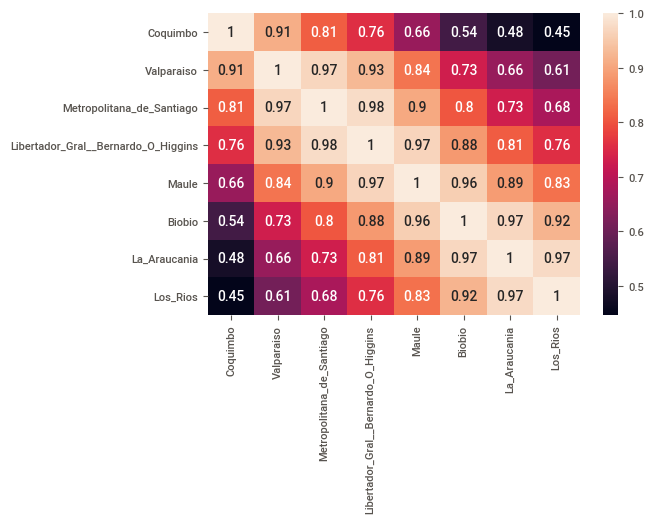

In [39]:
sns.heatmap(df_precipitaciones.corr(), annot=True)
plt.show()

Ahora, pasamos a revisar los datos del Banco Central:

In [93]:
df_banco_central = pd.read_csv("data/banco_central.csv")

Al intentar convertir la columna de Periodo en una fecha, encontramos que existe una columna con el mes 13 en el 2020 que eliminamos.

In [94]:
df_banco_central = df_banco_central[df_banco_central['Periodo']<='2020-12-01']
print("Revisión visual de las primeras filas de los datos del banco central:")
df_banco_central.head()

Revisión visual de las primeras filas de los datos del banco central:


,Periodo,Imacec_empalmado,Imacec_produccion_de_bienes,Imacec_minero,Imacec_industria,Imacec_resto_de_bienes,Imacec_comercio,Imacec_servicios,Imacec_a_costo_de_factores,Imacec_no_minero,...,Indice_de_tipo_de_cambio_real___TCR_promedio_1986_100,Indice_de_produccion_industrial,Indice_de_produccion_industrial__mineria,Indice_de_produccion_industrial_electricidad__gas_y_agua,Indice_de_produccion_industrial__manufacturera,Generacion_de_energia_electrica_CDEC_GWh,Indice_de_ventas_comercio_real_IVCM,Indice_de_ventas_comercio_real_no_durables_IVCM,Indice_de_ventas_comercio_real_durables_IVCM,Ventas_autos_nuevos
0,2013-03-01 00:00:00 UTC,102.796.218,10.546.824,978.554.365,102.297.537,114.994.919,110.729.395,100.064.328,103.163.651,103.405.852,...,865.903.468,102.761.705,98.915.705,NaN,108.387.837,580.480.672,NaN,NaN,NaN,28577.0
1,2013-04-01 00:00:00 UTC,101.664.842,999.272.757,927.333.293,104.485.589,102.199.311,106.098.291,102.600.107,101.937.319,102.766.884,...,867.806.065,968.087.179,914.276.663,NaN,104.545.429,544.815.032,NaN,NaN,NaN,32206.0
2,2013-05-01 00:00:00 UTC,101.642.954,993.959.922,96.133.164,105.445.361,968.789.055,100.462.117,104.083.216,101.953.299,102.322.796,...,878.030.947,978.471.874,966.913.278,NaN,99.468.801,56.891.916,NaN,NaN,NaN,31589.0
3,2013-06-01 00:00:00 UTC,998.310.201,968.367.884,102.400.933,999.212.106,89.190.493,939.504.414,103.857.161,100.222.381,995.139.235,...,913.180.348,966.647.135,981.820.974,NaN,94.969.678,56.594.867,NaN,NaN,NaN,28457.0
4,2013-07-01 00:00:00 UTC,964.696.194,961.051.418,980.029.022,100.882.112,901.785.886,92.776.599,969.309.272,962.069.134,962.804.305,...,909.263.447,100.100.749,990.198.382,NaN,102.128.977,586.329.899,NaN,NaN,NaN,31736.0


Nuevamente usamos sweetviz para hacer un rápido análisis de los datos en el reporte XXXX.

In [65]:
reporte_banco = sv.analyze(df_banco_central)
reporte_banco.show_html("report/banco_central.html")

                                             |          | [  0%]   00:00 -> (? left)

Report report/banco_central.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


En el dataset del banco central tenemos desde el año 1970 hasta el año 2020 distintos indicadores económicos. Principalmente Imacec y PIB por sectores, además de otros diversos indicadores. Nos encontramos con los siguientes problemas:
1. Tenemos algunos periodos repetidos, cuyos datos son idénticos, por lo que simplemente se elimina una observacción.

In [97]:
df_banco_central = df_banco_central.drop_duplicates('Periodo', keep='first')
df_banco_central = set_datetime_index(df_banco_central, 'Periodo') 
df_banco_central.loc['2019-08-01']

Periodo                                            2019-08-01 00:00:00 UTC
Imacec_empalmado                                               113.886.371
Imacec_produccion_de_bienes                                    103.237.519
Imacec_minero                                                  106.828.407
Imacec_industria                                               105.153.122
                                                            ...           
Generacion_de_energia_electrica_CDEC_GWh                              6598
Indice_de_ventas_comercio_real_IVCM                            116.203.109
Indice_de_ventas_comercio_real_no_durables_IVCM                107.385.297
Indice_de_ventas_comercio_real_durables_IVCM                    15.342.321
Ventas_autos_nuevos                                                33059.0
Name: 2019-08-01 00:00:00, Length: 85, dtype: object

2. Observando algunos campos del PIB, en especial el PIB_Industria_Manufacturera, vemos que el valor que más se repite es la letra a, con esto entendemos po qué este campo está siendo considerado como texto por pandas. Esto se repite en el resto de indicadores. Vemos que en el mayor de los casos se repite 4 veces, por lo que simplemente eliminamos esos datos.

In [108]:
print((df_banco_central=="a").sum(axis=0).sort_values(ascending=False)[0:5])
df_banco_central = df_banco_central.replace({'a': np.nan})

PIB_Industria_Manufacturera                                           4
Ocupacion_en_Suministro_de_agua_evacuacion_de_aguas_residuales_INE    4
PIB_Quimica                                                           3
PIB_Agropecuario_silvicola                                            1
PIB_Minerales_no_metalicos_y_metalica_basica                          1
dtype: int64


3. Luego, vemos que el 51% de los datos el Imacec es nulo. Asimismo, el 84% de los valores del PIB también lo es. Dado que el % es igual en cada una de las variables hace pensar que la pérdida de datos es sistemática y no aleatoria. Por eso, visualizamos la distribución de los valores perdidos.

    Dado que tenemos nuestro dataset ordenado por periodo, podemos ver que el problema es que los distintos indicadores se empiezan a calcular desde distintas fechas. Por ejemplo, los valores de Imacec comienzan en el año 1996 y los indicadores de PIB a partir del 2013. Por esto, no imputaremos valores, sino que más adelante desidiremos que periodo de datos utilizar.

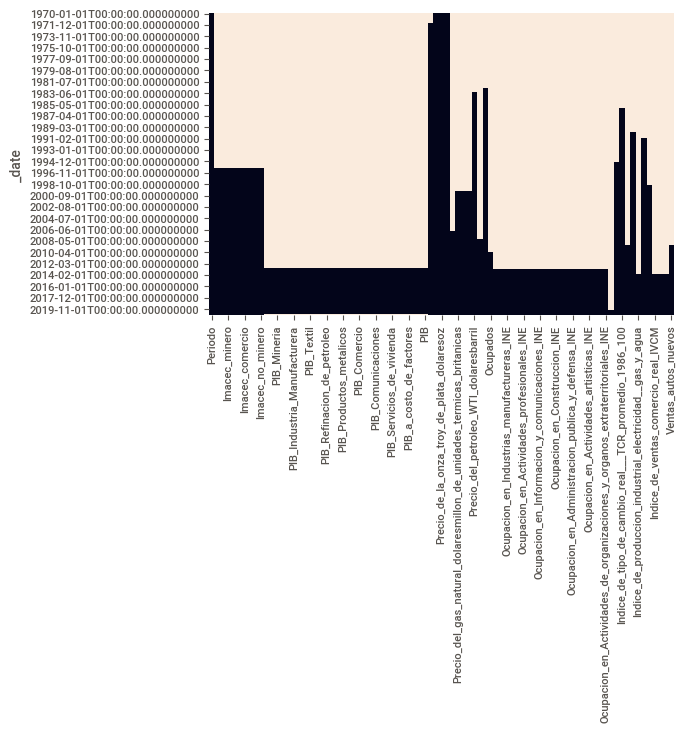

In [109]:
sns.heatmap(df_banco_central.isnull(), cbar=False)
plt.show()

4. Los datos del Imacec y PIB fueron interpretados como texto. Así que revisamos los valores para transformarlos en números. Creamos un nuevo reporte XXX para visualizar estos datos.

In [119]:
string_columns = [c for c in df_banco_central.select_dtypes('object').columns]
string_columns.remove('Periodo')
df_banco_central[string_columns] = df_banco_central[string_columns].apply(lambda x: x.str.replace('.', '', regex=False).astype(float), axis=1)

In [120]:
reporte_banco_2 = sv.analyze(df_banco_central)
reporte_banco_2.show_html("report/banco_central_numeric.html")

                                             |          | [  0%]   00:00 -> (? left)

Report report/banco_central_numeric.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


En este nuevo reporte se ve que las variables númericas PIB, Imacec y ocupación tienen valores en rangos muy grandes, desde valores bajo el millón hasta billones, por lo que habrá que revisar si puede ser una típica tendencia al alza u otro problema. Nos concentraremos en el PIB y el IMACEC que apriori podrían ser más relevantes para nuestro problema al estar separados por sectores y poder revisar los asociados a la leche.
1. Primero analizamos Imacec, desde la página del banco central se puede rescatar que típicamente su valr fluctúa entre 70 y 130, lo que no se corresponde con los valores de millones que vemos. Por eso vamos a situar el separador decimal dónde corresponde.

In [ ]:
def select_imacec(raw_imacec: float) -> float:
    """
    Toma un imacec y estima dónde debería ir el decimal
    """
    

In [123]:
x = 7.0
str(x)

'7.0'